Seperti biasanya, pertama-tama saya akan memanggil beberapa library pada Python untuk membantu proses Edge Detection dengan metode Canny. Library yang saya gunakan yaitu cv2 untuk melakukan Image Processing, numpy yang dialiaskan sebagai np untuk membantu beberapa operasi seperti pembuatan array maupun perhitungan, dan matplotlib.pyplot yang dialiaskan sebagai plt untuk memvisualisasikan gambar.

Langkah awal untuk melakukan proses Edge Detection adalah membaca gambar dari folder. Untuk dapat membaca sebuah gambar, saya menggunakan cv2.imread yang diikuti dengan sebuah parameter berupa nama file gambarnya. Setelah gambar berhasil dibaca, gambar akan disimpan ke dalam variabel image, lalu akan di-convert warnanya menjadi RGB dan Grayscale. 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('gereja-blenduk.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Langkah selanjutnya dalam melakukan Edge Detection menggunakan metode Canny adalah smoothing. Hal ini dikarenakan metode Canny sangat sensitif terhadap noise sehingga perlu dilakukan noise reduction dengan menggunakan Gaussian Blur (di sini saya menggunakan kernel sebesar 5x5). Namun, dikarenakan fungsi 'GaussianBlur' pada library cv2 tidak dapat menerima gambar dengan tipe data integer dan hanya dapat menerima tipe daya float, maka akan dilakukan proses pengubahan tipe data pada gambar terlebih dahulu dengan menggunakan fungsi 'astype'.

In [2]:
grayImage = grayImage.astype(np.float64)
blurImage = cv2.GaussianBlur(grayImage, (5, 5), 0)

Setelah dilakukan proses smoothing, langkah selanjutnya adalah menghitung gradien dan sudut arah pada gambar. Proses penghitungan ini dilakukan dengan memberikan filter sobel pada gambar. Di dalam fungsi 'sobelFilter', pertama-tama saya mendeklarasikan matrix gradien X dan matrix gradien Y. Setelah itu, masing-masing dari matrix ini akan dikonvolusikan ke gambar dengan bantuan library scipy dan fungsi 'ndimage.filters.convolve'. Hasil konvolusi akan disimpan pada variabel fX dan fY. 

Setelah nilai fX dan fY didapatkan, barulah kita dapat menghitung nilai gradien dengan cara mengakarkuadratkan hasil penjumlahan dari kuadrat fX dan kuadrat fY. Agar nilai gradien tidak terlalu besar maupun terlalu kecil, maka saya akan menskalakan nilai dari 0 - 255 dengan cara membagi gradien dengan nilai maksimum gradien yang dikalikan dengan 255. Sementara itu, untuk menghitung besar sudut arah gradien, dapat dilakukan dengan arcos tan dari fY dibagi fX. Fungsi 'sobelFilter' ini akan mengembalikan dua nilai yaitu gradien dan sudut arah.

In [3]:
import scipy.ndimage as sn

def sobelFilter(image):
    gradX = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]], np.float32)
    gradY = np.array([[1, 2, 1],
                      [0, 0, 0],
                      [-1, -2, -1]], np.float32)
    
    fX = sn.filters.convolve(image, gradX)
    fY = sn.filters.convolve(image, gradY)

    grad = np.sqrt(fX ** 2 + fY ** 2)
    grad = grad / grad.max() * 255
    angle = np.arctan2(fY, fX)

    return (grad, angle)

sobelImage, angle = sobelFilter(grayImage)

Langkah berikutnya dalam Edge Detection menggunakan metode Canny adalah dengan melakukan Non-Maximum Suppression, artinya nilai-nilai piksel yang tidak maksimal akan dihilangkan. Proses ini akan dilakukan satu persatu sehingga tiap-tiap piksel dari gambar akan diperiksa.

In [4]:
def NMS(image, D):
    width, height = image.shape
    base = np.zeros((width, height), dtype = np.int32)

    angle = D * 180 / np.pi
    angle[angle < 0] += 180

    for i in range(1, width - 1):
        for j in range(1, height - 1):
            q = 255
            r = 255
                
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = image[i, j+1]
                r = image[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                q = image[i+1, j-1]
                r = image[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                q = image[i+1, j]
                r = image[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                q = image[i-1, j-1]
                r = image[i+1, j+1]

            if (image[i,j] >= q) and (image[i,j] >= r):
                base[i,j] = image[i,j]
            else:
                base[i,j] = 0

    return base

nmsImage = NMS(sobelImage, angle)

<function matplotlib.pyplot.show(close=None, block=None)>

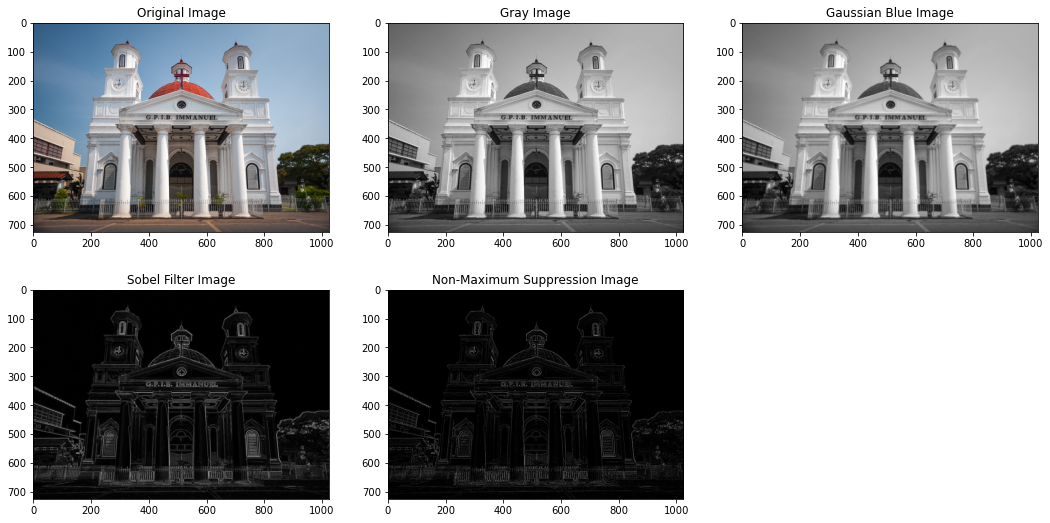

In [9]:
plt.figure(figsize = (18, 9))

plt.subplot(231)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(232)
plt.imshow(grayImage, cmap = "gray")
plt.title('Gray Image')

plt.subplot(233)
plt.imshow(blurImage, cmap = "gray")
plt.title('Gaussian Blue Image')

plt.subplot(234)
plt.imshow(sobelImage, cmap = "gray")
plt.title('Sobel Filter Image')

plt.subplot(235)
plt.imshow(nmsImage, cmap = "gray")
plt.title('Non-Maximum Suppression Image')

plt.show

Seperti yang dapat kita lihat pada visualisasi di atas, Sobel Filter sudah memberikan hasil berupa Edge Detection pada gambar. Namun, Edge Detection yang dihasilkan masih berbeda-beda untuk tiap edgesnya. Beberapa edges terlihat kecil, sementara beberapa lainnya terlihat besar. Untuk itu, dilakukan NMS agar besar piksel pada edges yang dihasilkan sama dan satu garis. Meskipun NMS sudah menghasilkan edges dengan besar yang sama, namun ketidakjelasan antara edges, objek, dan latar belakang masih terlihat. Untuk itu, perlu dilakukan proses thresholding. 

Pada proses thresholding ini, saya menentukan upper dan lower bound dari threshold sebesar 60 dan 10. Piksel yang bernilai lebih besar dari 60 akan dianggap sebagai strong edges. Piksel yang bernilai lebih kecil dari 10 akan dianggap bukan edges. Sementara piksel yang bernilai di antara 10 dan 60 akan dianggap sebagai weak edges. Setelah dilakukan proses thresholding, dapat kita lihat pada gambar bahwa edges pada gambar sudah terdeteksi dengan ukuran yang sama besar.

<function matplotlib.pyplot.show(close=None, block=None)>

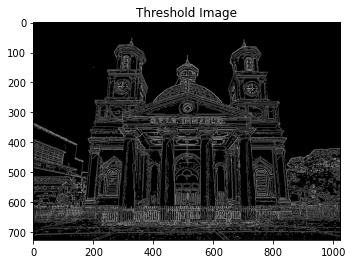

In [6]:

def threshold(image):
    low = 10
    high = 80

    width, height = image.shape
    base = np.zeros((width, height), dtype = np.int32)

    weak = np.int32(150)
    strong = np.int32(255)

    strongI, strongJ = np.where(image >= high)
    zerosI, zerosJ = np.where(image < low)
    weakI, weakJ = np.where((image <= high) & (image >= low))

    base[strongI, strongJ] = strong
    base[weakI, weakJ] = weak

    return base

thresImage = threshold(nmsImage)
plt.imshow(thresImage, cmap = "gray")
plt.title('Threshold Image')
plt.show

Sayangnya, hasil yang diberikan dari proses thresholding masih menunjukkan adanya weak pixels (piksel yang lemah yang masih belum bisa ditentukan apakah piksel tersebut merupakan latar belakang atau edge). Untuk itu diperlukan proses terakhir, yaitu hysteresis. Hysteresis akan memeriksa semua piksel lemah yang ada pada gambar, kemudian membandingkannya dengan semua neighbours yang ada. Apabila ada minimal satu neighbours dari piksel lemah yang merupakan strong edges, maka piksel tersebut akan dinyatakan sebagai strong edges. Sebaliknya, piksel akan dianggap latar belakang dan akan diubah nilainya menjadi 0. Dengan demikian, proses Edge Detection dengan metode Canny telah selesai dengan hasil seperti pada visualisasi di bawah.

<function matplotlib.pyplot.show(close=None, block=None)>

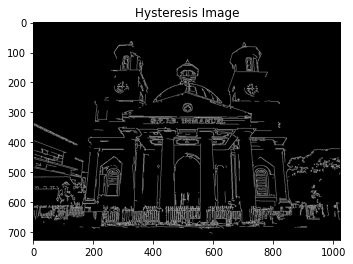

In [7]:
def hysteresis(image):
    width, height = image.shape

    weak = 150
    strong = 255

    for i in range(1, width - 1):
        for j in range(1, height - 1):

            if image[i, j] == weak:
                if ((image[i + 1, j - 1] == strong) or (image[i + 1, j] == strong) or
                    (image[i + 1, j + 1] == strong) or (image[i, j - 1] == strong) or
                    (image[i, j + 1] == strong) or (image[i - 1, j - 1] == strong) or
                    (image[i - 1, j] == strong) or (image[i - 1, j + 1] == strong)):
                    
                    image[i, j] = 255
                else:
                    image[i, j] = 0
    
    return image

hystImage = hysteresis(thresImage)
plt.imshow(hystImage, cmap = "gray")
plt.title('Hysteresis Image')
plt.show